In [1885]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
np.random.seed(42)

# **Primary Objective**: &emsp;Build a model that predicts whether an industry should be invested in on a particular date.

# **Data**: 12 Years of closing prices for main industry tickers including XLY, XLK, XLF, etc.


**Functions for ttm squeeze and determining if a closing price is a local max.**
* **is_n_high_day**: *Creates Is_Local_Max column.  Column indicates if a particular day is a local max for a particular industry. The function for local max does use the current days information, however only lag columns are used in the model. i.e All of the information fed to the model could be obtained without the current days data.*
* **get_TTM**: *Daily ttm values*
* **TTM_Weekly**: *Weekly ttm values*

In [1888]:
def donchian(df):
    max_high=df['High'].max()
    min_low=df['Low'].min()
    return (max_high+min_low)/2
def SMA(df):
    try:
        return df['Adj Close'].mean()
    except:
        return df['Close'].mean()
def Delta(df,donch,sma):
    try:
        return df['Adj Close'] - ( (donch + sma) / 2 )
    except:
        return df['Close'] - ( (donch + sma) / 2 )

def get_TTM(hist):
    #hist=hist.head(241)
    try:
        hist=hist.dropna(subset='Close')
    except:
        hist=hist.dropna(subset='Adj Close')
    hist=hist.sort_values(by='Date')
    len(hist)
    df=hist.iloc[:20].copy()
    donch=donchian(df)
    sma=SMA(df)
    deltas=Delta(df,donch,sma)
    
    lr=LinearRegression()
    X=np.array([i for i in range(20)]).reshape(-1,1)
    print(len(deltas),len(df),len(X))
    lr.fit(X,deltas)
    df[f'TTM']=lr.predict(X)
    list_of_values=[]
    metrics=[]
    smas=[]
    donches=[]
    first=True
    for i in range(20,len(hist)+1):
        df=hist.iloc[i-20:i]
        donch=donchian(df)
        sma=SMA(df)
        
        deltas=Delta(df,donch,sma)
        lr.fit(X,deltas)
        values=lr.predict(X)
        if first:
            first=False
            list_of_values=np.append(list_of_values,values)   
            metrics+=[(donch+sma)/2 for _ in range(20)]
            smas+=[sma for _ in range(20)]
            donches+=[donch for _ in range(20)]
        else:  
            values=values[-1]
            list_of_values=np.append(list_of_values,values)
            metrics.append((donch+sma)/2)
            smas.append(sma)
            donches.append(donch)
    hist[f'TTM']=list_of_values
    hist['metric']=metrics
    hist['donch']=donches
    hist['sma']=smas
    return hist
def is_n_day_high(df, n=20, price_column='Close'):
    """
    Determines if the closing price is at a maximum for the last n days,
    only considering past data for each date.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing price data
    n (int): Number of days to look back (default is 20)
    price_column (str): Name of the column containing closing prices (default is 'Close')
    
    Returns:
    pandas.Series: Boolean series where True indicates a n-day high
    """
    # Ensure the DataFrame is sorted by date in ascending order
    df = df.sort_values(by='Date')
    
    # Initialize the result series
    is_high = pd.Series(False, index=df.index)
    
    # Iterate through the DataFrame
    for i in range(n, len(df)):
        # Get the last n days of prices (including the current day)
        last_n_days = df[price_column].iloc[i-n+1:i+1]
        
        # Check if the current day's price is the maximum
        if df[price_column].iloc[i] == last_n_days.max():
            is_high.iloc[i] = True
    
    return is_high
def TTM_weekly(hist):
    # Assuming 'hist' is your original daily DataFrame
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist['Week']=hist['Date'].dt.isocalendar().week
    hist['Year']=hist['Date'].dt.year
    hist = hist.set_index('Date')

# Resample to weekly frequency
    weekly_hist = hist.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'Week': 'last',
    'Year': 'last'
})

    weekly_hist = weekly_hist.reset_index()
    # Set the number of weeks for calculation (e.g., 20 weeks instead of 20 days)
    WEEKS = 20
    
    weekly_hist = weekly_hist.sort_values(by='Date')
    weekly_hist
    weekly_hist = weekly_hist.dropna(subset=['Close'])
    
    df = weekly_hist.iloc[:WEEKS].copy()
    donch = donchian(df)
    sma = SMA(df)
    deltas = Delta(df, donch, sma)
    
    lr = LinearRegression()
    X = np.array([i for i in range(WEEKS)]).reshape(-1, 1)
    
    lr.fit(X, deltas)
    df['Weekly_TTM'] = lr.predict(X)
    
    list_of_values = []
    metrics = []
    smas = []
    donches = []
    first = True
    
    for i in range(WEEKS, len(weekly_hist) + 1):
        df = weekly_hist.iloc[i-WEEKS:i]
        donch = donchian(df)
        sma = SMA(df)
        
        deltas = Delta(df, donch, sma)
        lr.fit(X, deltas)
        values = lr.predict(X)
        
        if first:
            first = False
            list_of_values = np.append(list_of_values, values)   
            metrics += [(donch + sma) / 2 for _ in range(WEEKS)]
            smas += [sma for _ in range(WEEKS)]
            donches += [donch for _ in range(WEEKS)]
        else:  
            values = values[-1]
            list_of_values = np.append(list_of_values, values)
            metrics.append((donch + sma) / 2)
            smas.append(sma)
            donches.append(donch)
    
    weekly_hist['Weekly_TTM'] = list_of_values
    weekly_hist['metric'] = metrics
    weekly_hist['donch'] = donches
    weekly_hist['sma'] = smas
    hist=hist.reset_index()
    to_join=weekly_hist[['Week','Year','Weekly_TTM']]
    final_df=pd.merge(hist,to_join,on=['Week','Year'])
    return final_df



**Target**
* **Action**: *Flag that specifies if the percentage increase 20 days later is postive.  Variable is set by the set_action function*


**IsDecreasing Feature**
* *A column called isDecreasing is created.  The column uses the moving average to determine if the market is increasing/decreasing on a particular day.  The lag columns will be used as features*
  
**Other Targets considered**
* *There are also other columns that are created that were considered as possible targets.  For example, there is a column that indicates the magnitude of the percent change (20 days later), labeled 1-11*

In [1890]:
def is_decreasing_market(df, period=20, method='moving_average', threshold=0.05):
    """
    Identify decreasing market conditions using various methods.
    
    :param df: DataFrame with 'Date' and 'Close' columns
    :param period: Number of days to consider
    :param method: 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'
    :param threshold: Threshold for considering market as decreasing
    :return: DataFrame with 'isDecreasing' column
    """
    df = df.sort_values(by='Date').copy()
    
    if method == 'moving_average':
        df['MA'] = df['Close'].rolling(window=period).mean()
        df['isDecreasing'] = df['Close'] < df['MA']
    
    elif method == 'linear_regression':
        def rolling_regression(x):
            return stats.linregress(range(len(x)), x)[0]
        df['Slope'] = df['Close'].rolling(window=period).apply(rolling_regression)
        df['isDecreasing'] = df['Slope'] < 0
    
    elif method == 'percent_change':
        df['PercentChange'] = df['Close'].pct_change(periods=period)
        df['isDecreasing'] = df['PercentChange'] < -threshold
    
    elif method == 'drawdown':
        df['Rolling_Max'] = df['Close'].rolling(window=period, min_periods=1).max()
        df['Drawdown'] = (df['Close'] - df['Rolling_Max']) / df['Rolling_Max']
        df['isDecreasing'] = df['Drawdown'] < -threshold
    
    else:
        raise ValueError("Invalid method. Choose 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'.")
    
    return df
def set_action(df, holding_period):
    df['Action']=df[f'Future_Close{holding_period}'] > df['Close']
    df['Action'] = df['Action'].fillna(~df['isDecreasing'])
    return df
def performance_categories(row):
    if row['Future_pct_change']<0 and row['Future_pct_change']>=-0.1:
        return 6
    elif row['Future_pct_change']<-0.1 and row['Future_pct_change']>=-0.2:
        return 7
    elif row['Future_pct_change']<-0.2 and row['Future_pct_change']>=-1:
        return 8
    elif row['Future_pct_change']<-1 and row['Future_pct_change']>=-2.5:
        return 9
    elif row['Future_pct_change']<-2.5 and row['Future_pct_change']>=-5:
        return 10
    elif row['Future_pct_change']<-5:
        return 11
    elif row['Future_pct_change']>=0 and row['Future_pct_change']<=0.1:
        return 5
    elif row['Future_pct_change']>0.1 and row['Future_pct_change']<=0.2:
        return 4
    elif row['Future_pct_change']>0.2 and row['Future_pct_change']<=1:
        return 3
    elif row['Future_pct_change']>1 and row['Future_pct_change']<=2.5:
        return 2
    elif row['Future_pct_change']>2.5 and row['Future_pct_change']<=5:
        return 1
    elif row['Future_pct_change']>5:
        return 0
def create_performance_label(df,holding_period):
    df['Future_pct_change']=(df[f'Future_Close{holding_period}']-df[f'Close'])/df['Close']
    df['Performance_Label']=df.apply(performance_categories,axis=1)
    return df
    

# Creation of Lag columns 
**Lag columns for Close, Volume, Is_Local_Max, isDecreasing, and TTM_Daily and or TTM_Weekly**

In [1892]:
import pandas as pd
def calculate_weekly_ttm_change(joined, TTM_type='Weekly', num_lags=5):
    if TTM_type == 'Weekly':
        # Group by Year and Week, get the last TTM value for each week
        weekly_ttm = joined.groupby(['Year', 'Week'])['Weekly_TTM'].last().reset_index()
        weekly_ttm=weekly_ttm.sort_values(by=['Year','Week'])
        # Calculate the change from the last week
        weekly_ttm['TTM_Weekly_change'] = weekly_ttm['Weekly_TTM'].diff()
        
        # Create lags of the TTM change
        for lag in range(1, num_lags + 1):
            weekly_ttm[f'TTM_Weekly_change_lag{lag}'] = weekly_ttm['TTM_Weekly_change'].shift(lag)
        
        # Merge the weekly changes back to the original dataframe
        joined = pd.merge(joined, weekly_ttm.drop('Weekly_TTM', axis=1), on=['Year', 'Week'], how='left')
    else:
        # If not weekly, calculate daily changes
        joined['TTM_change'] = joined.groupby('Year')['TTM'].diff()
        for lag in range(1, num_lags + 1):
            joined[f'TTM_change_lag{lag}'] = joined.groupby('Year')['TTM_change'].shift(lag)
    
    return joined

def create_lags(joined,TTM_type='Weekly'):
    joined=joined.sort_values(by='Date')
    cols = ['Close']

    # Calculate percent change for each column and create new columns for the percent change
    for col in cols:
        joined[f'{col}_pct_change'] = joined[col].pct_change() * 100  # Multiply by 100 to convert to percentage
    
    # Create lagged features for the last 20 days of percent changes
    for col in cols:
        for i in range(1, 21):  # Start from 1 to 20
            joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
    cols2=['TTM']
    if TTM_type in ['Weekly','Both']:
        joined=calculate_weekly_ttm_change(joined)
    if TTM_type in ['Both','Daily']:
        for col in cols2:
            joined[f'{col}_change'] = joined['TTM'] - joined['TTM'].shift(1)
        for col in cols2:
            for i in range(1, 14):  # Start from 1 to 20
                #joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
                joined[f'{col}_change_lag{i}'] = joined[f'{col}_change'].shift(i)
                joined[f'{col}_raw_lag{i}']=joined[col].shift(i)
    
    cols3 = ['Is_Local_Max']
    for col in cols3:
        for i in range(1, 20):
            lagged_col = f'{col}_lag{i}'
            joined[lagged_col] = joined[col].shift(i)
            # Fill NaN values with False and convert to boolean
            joined[lagged_col] = joined[lagged_col].fillna(False).astype(bool)
    cols4=['Volume']
    for col in cols4:
        joined[f'{col}_log_change'] = np.log1p(joined[col] / joined[col].shift(1))
    for col in cols4:
        for i in range(1, 14):  # Start from 1 to 20
            joined[f'{col}_log_change_lag{i}'] = joined[f'{col}_log_change'].shift(i)
    cols5=['isDecreasing']
    for col in cols5:
        for i in range(1,20):
            joined[f'{col}_lag{i}']=joined[col].shift(i).astype(float)
    return joined






# Add VOO to the data
*The data for the overall market is used.*

In [1894]:

start_date = '2012-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
holding_period=20
# Fetch VOO data
voo = yf.Ticker("VOO")
df_voo= voo.history(start=start_date, end=end_date).reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date']).dt.date
df_voo['Ticker']='VOO'
print(len(df_voo),'length')
TTM_type='Both'

df_voo['Is_Local_Max']=is_n_day_high(df_voo, n=holding_period, price_column='Close')
if TTM_type in ['Weekly','Both']:
    df_voo=TTM_weekly(df_voo)
if TTM_type in ['Daily','Both']:
    df_voo=get_TTM(df_voo)
print(df_voo.info())
df_voo=is_decreasing_market(df_voo)

df_voo[f'Future_Close{holding_period}'] = df_voo['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
df_voo[f'Future_Close{holding_period-1}']=df_voo['Close'].shift(-1*(holding_period-1)) 
df_voo[f'Future_Close{holding_period+1}']=df_voo['Close'].shift(-1*(holding_period+1))

df_voo=set_action(df_voo,holding_period)
df_voo=df_voo.reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date'])
df_voo['Month']=df_voo['Date'].dt.month
df_voo['Year']=df_voo['Date'].dt.year
df_voo=create_performance_label(df_voo,holding_period)
df_voo=create_lags(df_voo,TTM_type=TTM_type)
df_voo.head()

3193 length
20 20 20
<class 'pandas.core.frame.DataFrame'>
Index: 3193 entries, 0 to 3192
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3193 non-null   datetime64[ns]
 1   Open           3193 non-null   float64       
 2   High           3193 non-null   float64       
 3   Low            3193 non-null   float64       
 4   Close          3193 non-null   float64       
 5   Volume         3193 non-null   int64         
 6   Dividends      3193 non-null   float64       
 7   Stock Splits   3193 non-null   float64       
 8   Capital Gains  3193 non-null   float64       
 9   Ticker         3193 non-null   object        
 10  Is_Local_Max   3193 non-null   bool          
 11  Week           3193 non-null   UInt32        
 12  Year           3193 non-null   int32         
 13  Weekly_TTM     3193 non-null   float64       
 14  TTM            3193 non-null   float64       
 15  metri

index       Date       Open       High        Low      Close  Volume  \
0      0 2012-01-03  93.068778  93.514614  92.829933  92.829933  163250   
1      1 2012-01-04  92.702571  93.084714  92.320421  92.989182  448450   
2      2 2012-01-05  92.575182  93.387249  92.097500  93.291710  253500   
3      3 2012-01-06  93.387235  93.387235  92.734400  93.100624  166900   
4      5 2012-01-09  93.259862  93.339475  92.782179  93.243942  177000   

   Dividends  Stock Splits  Capital Gains  ... isDecreasing_lag10  \
0        0.0           0.0            0.0  ...                NaN   
1        0.0           0.0            0.0  ...                NaN   
2        0.0           0.0            0.0  ...                NaN   
3        0.0           0.0            0.0  ...                NaN   
4        0.0           0.0            0.0  ...                NaN   

   isDecreasing_lag11  isDecreasing_lag12  isDecreasing_lag13  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag14  isDecreasing_lag15  isDecreasing_lag16  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag17  isDecreasing_lag18  isDecreasing_lag19  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

[5 rows x 134 columns]

# Action Label
**Future_pct_change is the percent change between the closing price and the closing price 20 days later**

In [1896]:
df_voo[['Action','Future_pct_change']].sample(20)

Action  Future_pct_change
1029    True           0.067727
1001   False          -0.074850
785     True           0.001349
411     True           0.032873
1105    True           0.012643
612     True           0.012036
610     True           0.008651
2268    True           0.022901
134     True           0.039386
1842   False          -0.043800
1866    True           0.061171
1374    True           0.016357
368     True           0.066030
2002    True           0.040684
1457    True           0.008864
1161   False          -0.026856
1423    True           0.026669
2236    True           0.036357
471    False          -0.004727
756     True           0.021171

# isDecreasing feature
*This was also considered as the target.  You can see in the sample that is decreasing does not always indicate a non profitable investment day.*

In [1898]:
df_voo[['isDecreasing','Action','Future_pct_change']].iloc[20:50]

isDecreasing  Action  Future_pct_change
20         False    True           0.039776
21         False    True           0.034920
22         False    True           0.016079
23         False    True           0.001627
24         False    True           0.006486
25         False    True           0.014078
26         False    True           0.016809
27         False    True           0.024247
28         False    True           0.034722
29         False    True           0.035420
30         False    True           0.045322
31         False    True           0.035513
32         False    True           0.037351
33         False    True           0.033803
34         False    True           0.035685
35         False    True           0.022717
36         False    True           0.025240
37         False    True           0.037296
38         False    True           0.030797
39         False    True           0.031421
40         False    True           0.022955
41         False    True           0.029081
42         False    True           0.041871
43          True    True           0.054373
44          True    True           0.035046
45         False    True           0.024815
46         False    True           0.009570
47         False   False          -0.008466
48         False   False          -0.017958
49         False   False          -0.003698

# Add each industry sector to the data

In [1900]:

sector_stocks = {
    'XLY': ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'BKNG', 'LOW', 'TJX', 'SBUX', 'CMG'],
    'XLP': ['PG', 'PEP', 'KO', 'COST', 'WMT', 'PM', 'MDLZ', 'CL', 'MO', 'TGT'],
    'XLE': ['XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'WMB', 'VLO', 'OKE'],
    'XLF': ['BRK-B', 'JPM', 'BAC', 'WFC', 'GS', 'V', 'MA', 'BAC', 'WFC', 'GS', 'SPGI', 'AXP', 'PGR'],
    'XLV': ['UNH', 'JNJ', 'LLY', 'PFE', 'ABT', 'MRK', 'ABBV', 'TMO', 'AMGN', 'DHR', 'PFE'],
    'XLI': ['UNP', 'HON', 'UPS', 'CAT', 'GE', 'UBER', 'HON', 'RTX', 'ETN', 'BA', 'UPS', 'LMT'],
    'XLB': ['LIN', 'FCX', 'APD', 'ECL', 'NEM', 'SHW', 'NUE', 'CTVA', 'DOW', 'DD'],
    'XLRE': ['PLD', 'AMT', 'CCI', 'EQIX', 'PSA', 'WELL', 'SPG', 'DLR', 'O', 'EXR'],
    'XLK': ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'AMD', 'CRM', 'ADBE', 'ORCL', 'QCOM', 'AMAT'],
    'XLC': ['META', 'GOOGL', 'NFLX', 'CMCSA', 'T', 'VZ', 'EA', 'TMUS', 'DIS'],
    'XLU': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'CEG', 'SRE', 'PCG', 'PEG', 'EXC']
}

def add_ticker(df,ticker_str,start_date,holding_period,TTM_type='Both'):
    df2=df.copy()
    
    end_date = datetime.today().strftime('%Y-%m-%d')

    holding_period=20
# Fetch VOO data
    ticker= yf.Ticker(ticker_str)
    new_df= ticker.history(start=start_date, end=end_date).reset_index()
    if new_df['Volume'].min()==0:
        new_df=new_df[new_df['Volume']!=0]
    pd.to_datetime(new_df['Date']).dt.tz_localize(None).dt.date
    new_df['Month']=new_df['Date'].dt.month
    new_df['Year']=new_df['Date'].dt.year
    new_df['Ticker']=ticker_str
    if TTM_type in ['Weekly','Both']:
        new_df=TTM_weekly(new_df)
    if TTM_type in ['Daily','Both']:
        new_df=get_TTM(new_df)
    

    new_df=is_decreasing_market(new_df)
    #new_df['Future_Close'] = new_df['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
    new_df[f'Future_Close{holding_period}'] = new_df['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
    new_df[f'Future_Close{holding_period-1}']=new_df['Close'].shift(-1*(holding_period-1)) 
    new_df[f'Future_Close{holding_period+1}']=new_df['Close'].shift(-1*(holding_period+1))
    new_df=set_action(new_df,holding_period)
    new_df['Is_Local_Max']=is_n_day_high(new_df, n=holding_period, price_column='Close')
    new_df=create_lags(new_df,TTM_type=TTM_type)
    new_df=create_performance_label(new_df,holding_period)
    df2=pd.concat([df2,new_df])
    return df2
for ticker in sector_stocks.keys():                
    df_voo=add_ticker(df_voo,ticker ,start_date,holding_period)
df_voo.head()

20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20
20 20 20


index                 Date       Open       High        Low      Close  \
0    0.0  2012-01-03 00:00:00  93.068778  93.514614  92.829933  92.829933   
1    1.0  2012-01-04 00:00:00  92.702571  93.084714  92.320421  92.989182   
2    2.0  2012-01-05 00:00:00  92.575182  93.387249  92.097500  93.291710   
3    3.0  2012-01-06 00:00:00  93.387235  93.387235  92.734400  93.100624   
4    5.0  2012-01-09 00:00:00  93.259862  93.339475  92.782179  93.243942   

   Volume  Dividends  Stock Splits  Capital Gains  ... isDecreasing_lag10  \
0  163250        0.0           0.0            0.0  ...                NaN   
1  448450        0.0           0.0            0.0  ...                NaN   
2  253500        0.0           0.0            0.0  ...                NaN   
3  166900        0.0           0.0            0.0  ...                NaN   
4  177000        0.0           0.0            0.0  ...                NaN   

   isDecreasing_lag11  isDecreasing_lag12  isDecreasing_lag13  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag14  isDecreasing_lag15  isDecreasing_lag16  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag17  isDecreasing_lag18  isDecreasing_lag19  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

[5 rows x 134 columns]

In [1901]:
df_voo['Date'] = pd.to_datetime(df_voo['Date'], utc=True).dt.tz_localize(None)

In [1902]:
print('Number of Rows in Data set:',len(df_voo))

Number of Rows in Data set: 35738


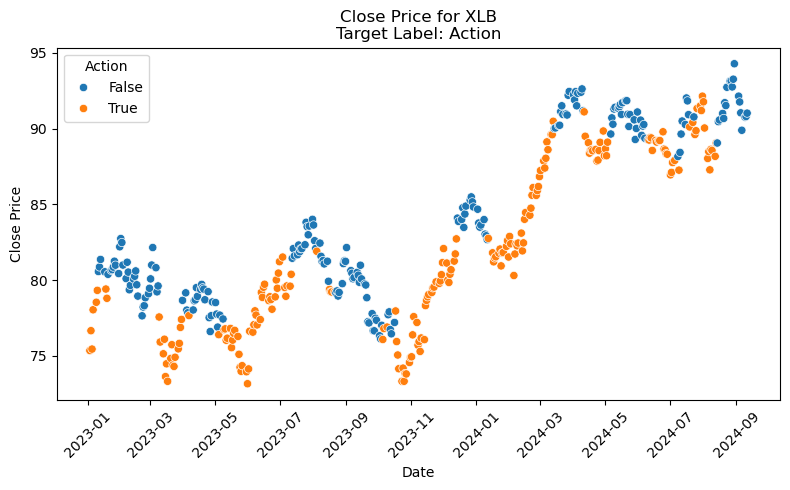

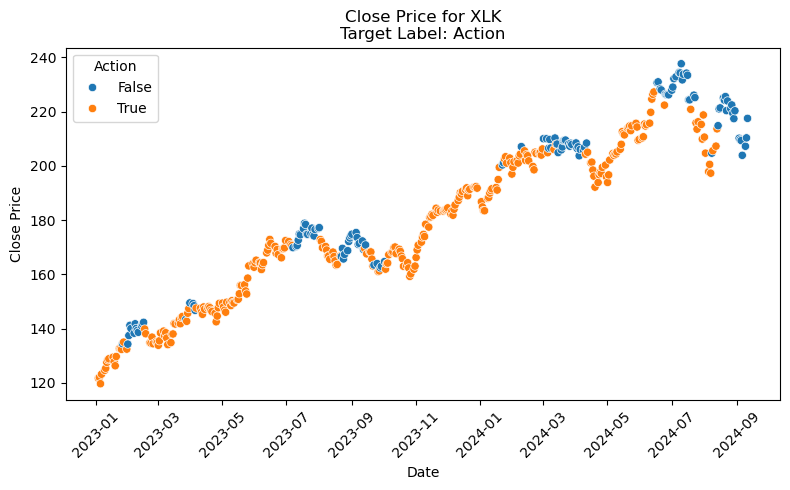

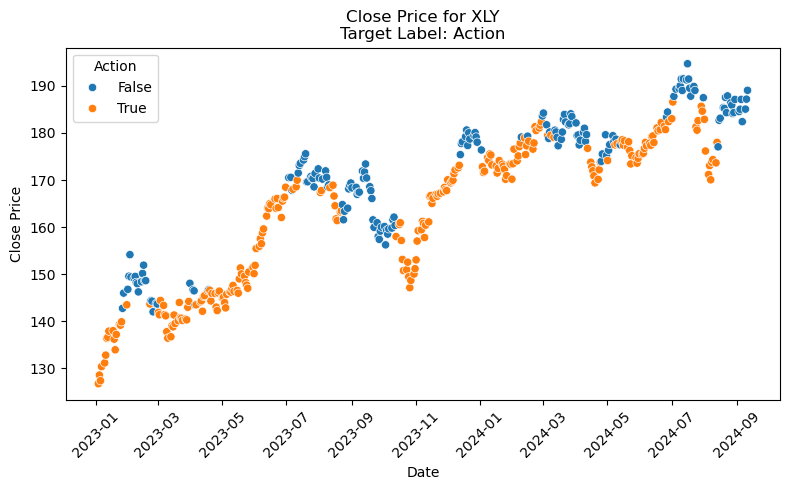

In [1903]:
def plot_hue_column(df,column='Action',plot_one=False,plot_three=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')

    if plot_three:
        for ticker in ['XLB','XLK','XLY']:
            data = df[df['Ticker'] == ticker]
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        return None
    
    # Now plot for each ticker
    for ticker in sector_stocks.keys():
        data = df[df['Ticker'] == ticker]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break

testing_period=df_voo[df_voo['Year']>2022]
plot_hue_column(testing_period,column='Action',plot_three=True)

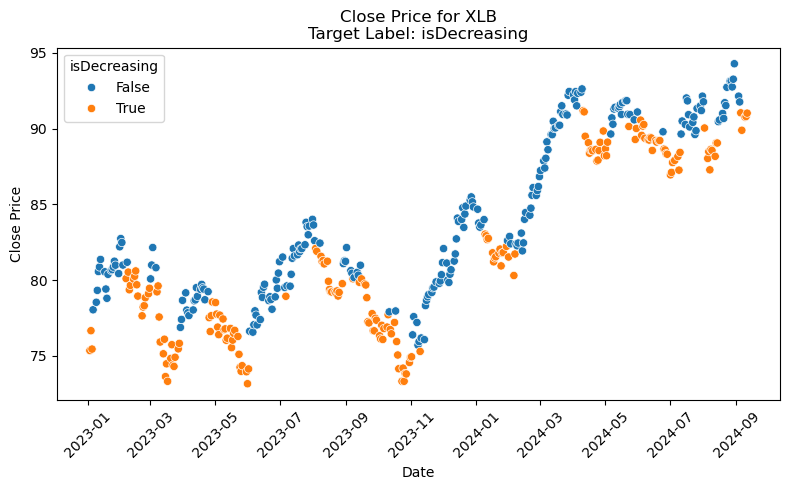

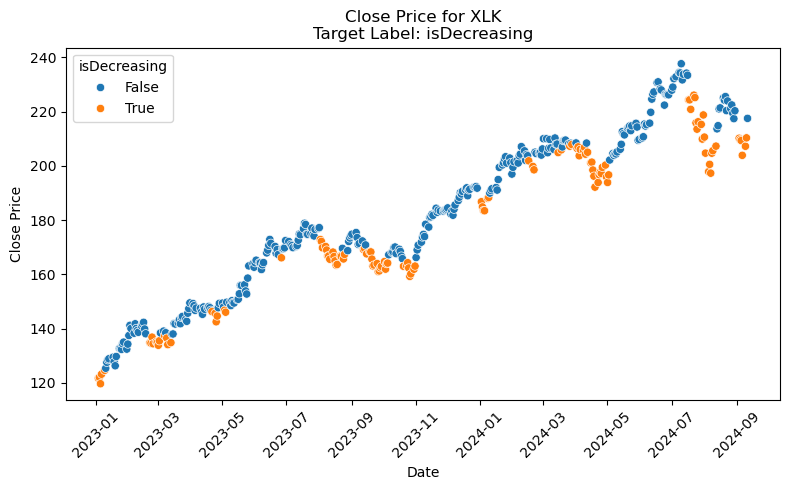

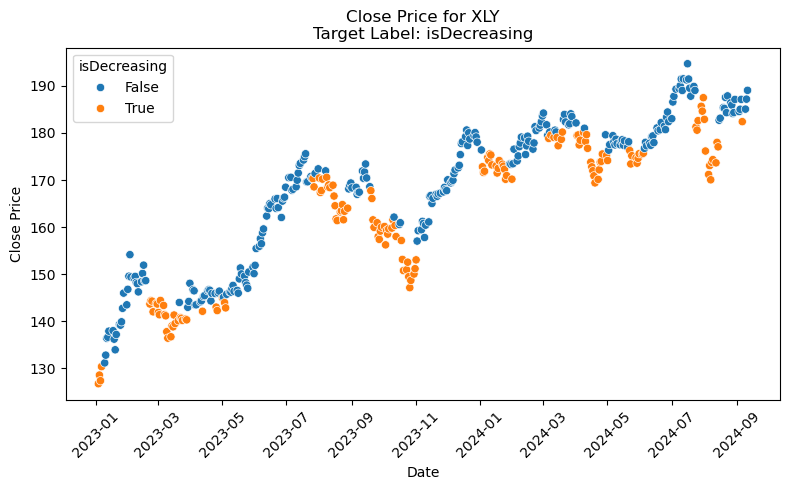

In [1904]:
plot_hue_column(testing_period,column='isDecreasing',plot_three=True)

# Is Local Max
**The Is_Local_Max variable indicates if the closing price is a local max based on the previous 20 days.  Its lags can be used as a feature which could be another indicator of increasing decreasing behavior, or potentially the end of increasing behavior.**

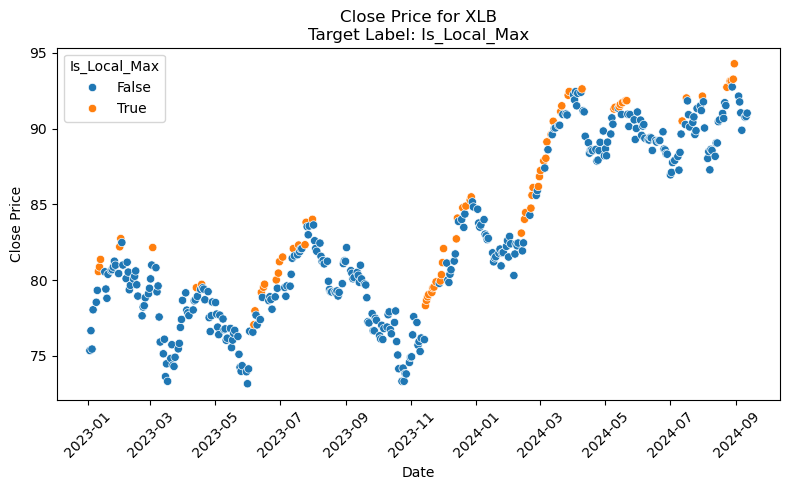

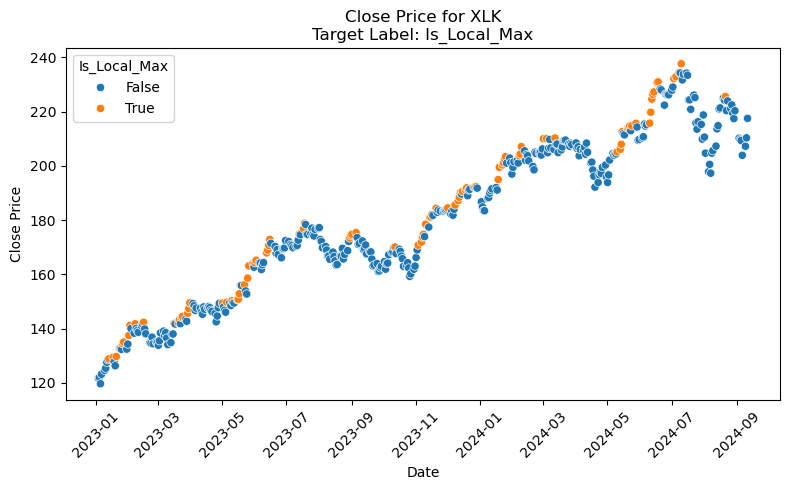

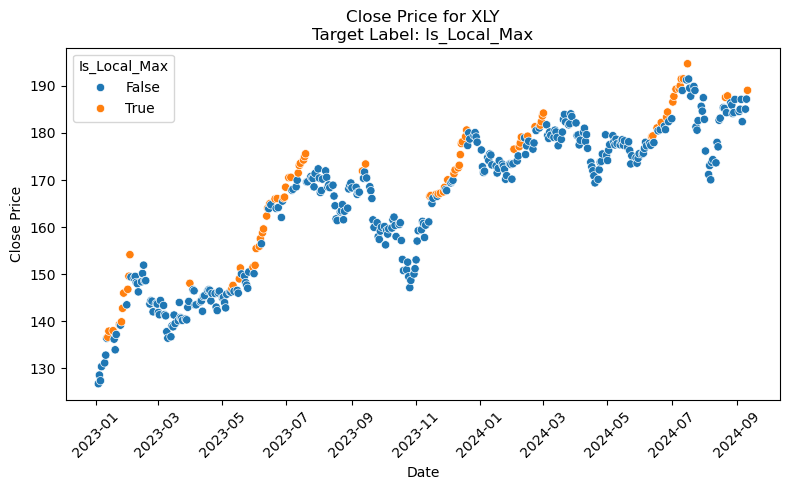

In [1906]:
plot_hue_column(testing_period, column='Is_Local_Max',plot_three=True)

# Add The federal Funds rate and Unemployment rate to the data

In [1908]:

# Fetch the federal funds rate data
fed_funds_rate = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)


# Fetch the unemployment rate data
unemployment_rate = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)

print(unemployment_rate.head())
print("\nMost recent unemployment rate:")
print(unemployment_rate.tail(1))

fed_funds_rate=fed_funds_rate.reset_index()
fed_funds_rate['DATE']=pd.to_datetime(fed_funds_rate['DATE'])
unemployment_rate=unemployment_rate.reset_index()
unemployment_rate['DATE']=pd.to_datetime(unemployment_rate['DATE'])
fed_funds_rate['Month']=fed_funds_rate['DATE'].dt.month
fed_funds_rate['Year']=fed_funds_rate['DATE'].dt.year
unemployment_rate['Month']=unemployment_rate['DATE'].dt.month
unemployment_rate['Year']=unemployment_rate['DATE'].dt.year
joined=pd.merge(df_voo,fed_funds_rate,on=['Month','Year'])
joined=pd.merge(joined,unemployment_rate,on=['Month','Year'])
try:
    joined=joined.drop(columns=['DATE_x','DATE_y'])
except:
    print('No duplicated date columns')

            UNRATE
DATE              
2012-01-01     8.3
2012-02-01     8.3
2012-03-01     8.2
2012-04-01     8.2
2012-05-01     8.2

Most recent unemployment rate:
            UNRATE
DATE              
2024-08-01     4.2


In [1909]:
df_voo.isnull().sum()

index                 32545
Date                      0
Open                      0
High                      0
Low                       0
                      ...  
isDecreasing_lag15      180
isDecreasing_lag16      192
isDecreasing_lag17      204
isDecreasing_lag18      216
isDecreasing_lag19      228
Length: 134, dtype: int64

# Add consumer price index to the data.

In [1911]:
# Fetch Consumer Price Index (CPI) data
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)

# Fetch Consumer Confidence Index data
#cci = pdr.get_data_fred('CSCICP03USM665S', start=start_date, end=end_date)

print("Consumer Price Index (CPI):")
print(cpi.tail())


cpi.columns = ['CPI']
cpi=cpi.reset_index()
cpi['Month']=cpi['DATE'].dt.month
cpi['Year']=cpi['DATE'].dt.year
joined=pd.merge(joined,cpi, on=['Month','Year'])

Consumer Price Index (CPI):
            CPIAUCSL
DATE                
2024-04-01   313.207
2024-05-01   313.225
2024-06-01   313.049
2024-07-01   313.534
2024-08-01   314.121


# Add lag columns for Unemployment rate, Federal Funds rate, and CPI.

In [1913]:
import yfinance as yf

# Assuming start_date and end_date are already defined
vix = yf.Ticker("^VIX")
vix_data = vix.history(start=start_date, end=end_date)
vix_data=vix_data.rename(columns={'Close':'Vix_Close'}).reset_index()
vix_data['Date']=vix_data['Date'].dt.date
vix_data=vix_data[['Date','Vix_Close']]



# Assuming start_date and end_date are already defined
hyg = yf.Ticker("HYG")
hyg_data = hyg.history(start=start_date, end=end_date)

try:
    joined['Date']=joined['Date'].dt.date
except:
    print()
hyg_data=hyg_data.rename(columns={'Close':'HYG_Close'}).reset_index()
hyg_data=hyg_data[['Date','HYG_Close']]
hyg_data['Date']=hyg_data['Date'].dt.date
joined=pd.merge(joined,vix_data, on='Date')
joined=pd.merge(joined,hyg_data,on='Date')

In [1914]:
joined['HYG_Close'].describe()

count    35654.000000
mean        62.149053
std          8.474202
min         44.892208
25%         54.623260
50%         62.153946
75%         68.973183
max         79.019714
Name: HYG_Close, dtype: float64

In [1915]:
# Assuming 'joined' is your DataFrame with the necessary columns
cols = ['UNRATE', 'FEDFUNDS', 'CPI']
agg_d={col:'first' for col in cols}
grouped=joined.groupby(['Month','Year']).agg(agg_d).reset_index()
grouped=grouped.sort_values(by=['Year','Month'])
for col in cols:
    # Calculate the percent change and create a new column
    grouped[f'{col}_pct_change'] = grouped[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 2 days of percent changes
for col in cols:
    for i in range(1, 3):  # Create lagged features for 1 and 2 days
        grouped[f'{col}_pct_change_lag{i}'] = grouped[f'{col}_pct_change'].shift(i)
joined=pd.merge(joined,grouped,on=['Month','Year'])

cols2=['Vix_Close','HYG_Close']
agg_d={col:'first' for col in cols2}
grouped2=joined.groupby(['Date']).agg(agg_d).reset_index()
grouped2=grouped2.sort_values(by='Date')
for col in cols2:
    # Calculate the percent change and create a new column
    grouped2[f'{col}_pct_change'] = grouped2[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 2 days of percent changes
for col in cols2:
    for i in range(1, 20):  # Create lagged features for 1 and 2 days
        grouped2[f'{col}_pct_change_lag{i}'] = grouped2[f'{col}_pct_change'].shift(i)
joined=pd.merge(joined,grouped2,on='Date')

In [1916]:
joined

index        Date        Open        High         Low       Close  \
0        0.0  2012-01-03   93.068778   93.514614   92.829933   92.829933   
1        NaN  2012-01-03   34.046050   34.166205   33.771416   33.771416   
2        NaN  2012-01-03   23.400842   23.465267   23.229041   23.236198   
3        NaN  2012-01-03   45.283260   45.796387   45.212705   45.571896   
4        NaN  2012-01-03    8.528564    8.650584    8.522142    8.567097   
...      ...         ...         ...         ...         ...         ...   
35649    NaN  2024-08-30   93.519997   94.419998   93.070000   94.279999   
35650    NaN  2024-08-30   43.340000   43.570000   43.000000   43.549999   
35651    NaN  2024-08-30  219.809998  221.179993  217.440002  220.330002   
35652    NaN  2024-08-30   87.160004   87.389999   86.440002   87.320000   
35653    NaN  2024-08-30   75.860001   76.400002   75.580002   76.290001   

          Volume  Dividends  Stock Splits  Capital Gains  ...  \
0         163250        0.0           0.0            0.0  ...   
1       12055500        0.0           0.0            0.0  ...   
2       20757900        0.0           0.0            0.0  ...   
3       24254800        0.0           0.0            0.0  ...   
4      103362023        0.0           0.0            0.0  ...   
...          ...        ...           ...            ...  ...   
35649    4323700        0.0           0.0            0.0  ...   
35650    5611600        0.0           0.0            0.0  ...   
35651    5024200        0.0           0.0            0.0  ...   
35652    3072400        0.0           0.0            0.0  ...   
35653    8503700        0.0           0.0            0.0  ...   

      HYG_Close_pct_change_lag10  HYG_Close_pct_change_lag11  \
0                            NaN                         NaN   
1                            NaN                         NaN   
2                            NaN                         NaN   
3                            NaN                         NaN   
4                            NaN                         NaN   
...                          ...                         ...   
35649                   0.318106                    0.089148   
35650                   0.318106                    0.089148   
35651                   0.318106                    0.089148   
35652                   0.318106                    0.089148   
35653                   0.318106                    0.089148   

       HYG_Close_pct_change_lag12  HYG_Close_pct_change_lag13  \
0                             NaN                         NaN   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
35649                    0.178615                    0.461421   
35650                    0.178615                    0.461421   
35651                    0.178615                    0.461421   
35652                    0.178615                    0.461421   
35653                    0.178615                    0.461421   

       HYG_Close_pct_change_lag14  HYG_Close_pct_change_lag15  \
0                             NaN                         NaN   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
35649                    0.064115                   -0.012819   
35650                    0.064115                   -0.012819   
35651                    0.064115                   -0.012819   
35652                    0.064115                   -0.012819   
35653                    0.064115               

# A look at potential features

In [1918]:
features=[col for col in joined.columns if 'lag' in col]
for i in range(12,len(features)+1,12):
    print(", ".join(features[i-12:i]),end=',')

Close_pct_change_lag1, Close_pct_change_lag2, Close_pct_change_lag3, Close_pct_change_lag4, Close_pct_change_lag5, Close_pct_change_lag6, Close_pct_change_lag7, Close_pct_change_lag8, Close_pct_change_lag9, Close_pct_change_lag10, Close_pct_change_lag11, Close_pct_change_lag12,Close_pct_change_lag13, Close_pct_change_lag14, Close_pct_change_lag15, Close_pct_change_lag16, Close_pct_change_lag17, Close_pct_change_lag18, Close_pct_change_lag19, Close_pct_change_lag20, TTM_Weekly_change_lag1, TTM_Weekly_change_lag2, TTM_Weekly_change_lag3, TTM_Weekly_change_lag4,TTM_Weekly_change_lag5, TTM_change_lag1, TTM_raw_lag1, TTM_change_lag2, TTM_raw_lag2, TTM_change_lag3, TTM_raw_lag3, TTM_change_lag4, TTM_raw_lag4, TTM_change_lag5, TTM_raw_lag5, TTM_change_lag6,TTM_raw_lag6, TTM_change_lag7, TTM_raw_lag7, TTM_change_lag8, TTM_raw_lag8, TTM_change_lag9, TTM_raw_lag9, TTM_change_lag10, TTM_raw_lag10, TTM_change_lag11, TTM_raw_lag11, TTM_change_lag12,TTM_raw_lag12, TTM_change_lag13, TTM_raw_lag13, Is

# Drop rows where there are null values in the feature columns.  Null values are expected because of the lag columns.

In [1920]:
joined=joined.dropna(subset=features)
write_to_file=True
if write_to_file:
    joined.to_csv('Data_for_Model_2002_now.csv',index=False)
len(joined)


34970

# Ensure numeric data types

In [1922]:
from pandas.api.types import is_numeric_dtype
for col in joined[features].columns:
    if not is_numeric_dtype(joined[col]):
        print(col)

# Split data on Time. 70-30.

In [1924]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
ticker_dummies=True
if ticker_dummies:
    joined=pd.get_dummies(joined,columns=['Ticker'])

    features = [col for col in joined.columns if 'lag' in col] + ['Month']+[col for col in joined if 'Ticker' in col]
else:
    features = [col for col in joined.columns if 'lag' in col] + ['Month']

joined.sort_values(by='Date', inplace=True)
joined=joined.dropna(subset=features)
# Define the split point (e.g., 70% for training)
split_point = int(len(joined) * 0.7)

# Split the data into training and testing sets
train = joined.iloc[:split_point]
test = joined.iloc[split_point:]





# Create Xgboost model, Using the lag columns as features and Action as the target.  The industry ticker was also used as a categorical variable..

In [1926]:
# Create the XGBoost classifier
from sklearn.metrics import precision_score
features=[col for col in joined.columns if 'lag' in col]+[col for col in joined.columns if 'Ticker' in col]
X_train = train[features]
y_train=train['Action']
X_test = test[features]
y_test=test['Action']

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                           random_state=42)
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print('Precision', precision_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5645791630921743
Recall 0.7328597389724104
F1_score 0.6601190476190476
Precision 0.6005144172194395
              precision    recall  f1-score   support

       False       0.48      0.34      0.39      4438
        True       0.60      0.73      0.66      6053

    accuracy                           0.56     10491
   macro avg       0.54      0.53      0.53     10491
weighted avg       0.55      0.56      0.55     10491



**Predicts invest days fairly well, but generates a lot of false positives.  Overall, probably not the most helpful model.**

In [1928]:
from sklearn.metrics import confusion_matrix
import numpy as np

def print_custom_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Print the results
    print("False Negatives:", fn)
    print("True Negatives:", tn)
    print("\nAdditional Information:")
    print("True Positives:", tp)
    print("False Positives:", fp)
    
    # Calculate and print percentages
    total = tn + fp + fn + tp
    print("\nPercentages:")
    print(f"False Negatives: {fn/total:.2%}")
    print(f"True Negatives: {tn/total:.2%}")
    print(f"True Positives: {tp/total:.2%}")
    print(f"False Positives: {fp/total:.2%}")


print_custom_confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
negative_recall = tn / (tn + fp)
print(negative_recall)

False Negatives: 1617
True Negatives: 1487

Additional Information:
True Positives: 4436
False Positives: 2951

Percentages:
False Negatives: 15.41%
True Negatives: 14.17%
True Positives: 42.28%
False Positives: 28.13%
0.3350608382154123


**There is a higher percentage of False negatives than True negatives. The False negatives represent days that are profitable invest days but will be selected as non-invest days.  Also Noteworthy, is that there is a higher percentage of False positives, compared to true negatives.  This all indicates that the model has trouble predicting the non_invest days.  The model does better with predicting the positive class. If the model makes a positive prediction there is around 60%(precision) chance that the day is actually a profitable invest day.  68%(recall) of the actual invest days were identified as invest days by the model.** 

# Visual look at the predicted invest days/non_invest days.

In [1931]:
def plot_hue_column2(df,column='Action',plot_one=False,plot_three=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')
    
    # Now plot for each ticker
    ticker_columns=[col for col in df.columns if 'Ticker' in col]
    if plot_three:
        ticker_columns=[col for col in ticker_columns if col.split('_')[1] in ['XLB','XLK','XLY']]
    
        
    print(ticker_columns)
    for ticker in ticker_columns:
        data = df[df[ticker]]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break


['Ticker_XLB', 'Ticker_XLK', 'Ticker_XLY']


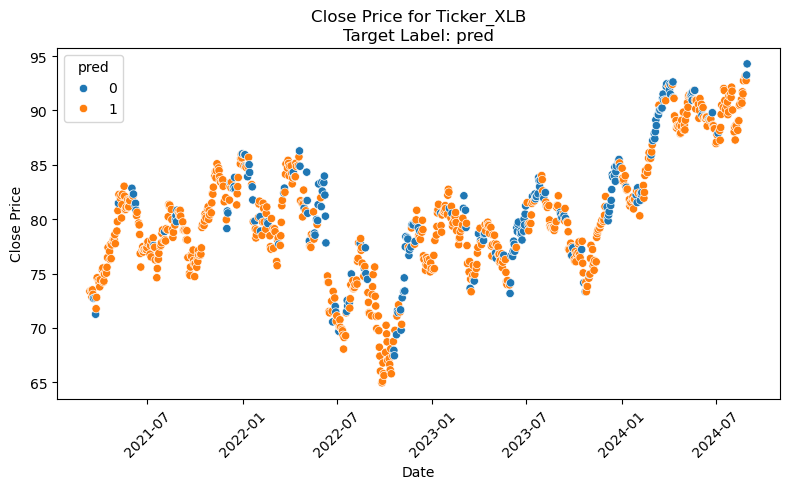

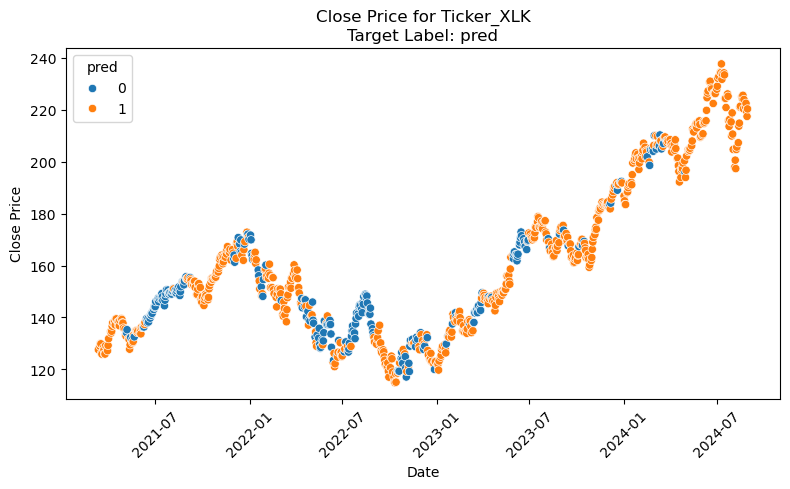

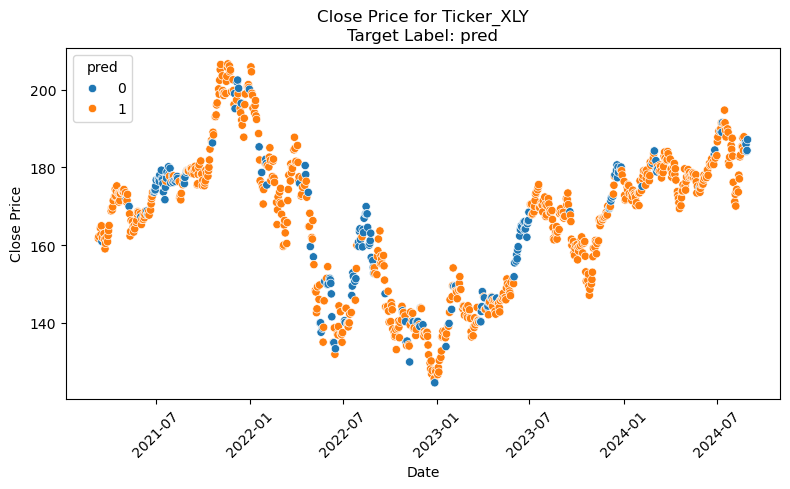

In [1932]:
test['pred']=y_pred
plot_hue_column2(test,column='pred',plot_three=True)
#test['Predicted_Action']=test['pred']
#test['Predicted_Action']=test.apply(lambda x: False if x['isDecreasing_lag1'] else x['Predicted_Action'], axis=1)
#test[['Date','isDecreasing']].to_csv('Action_Data.csv',index=False)

# Permutation Feature Importance

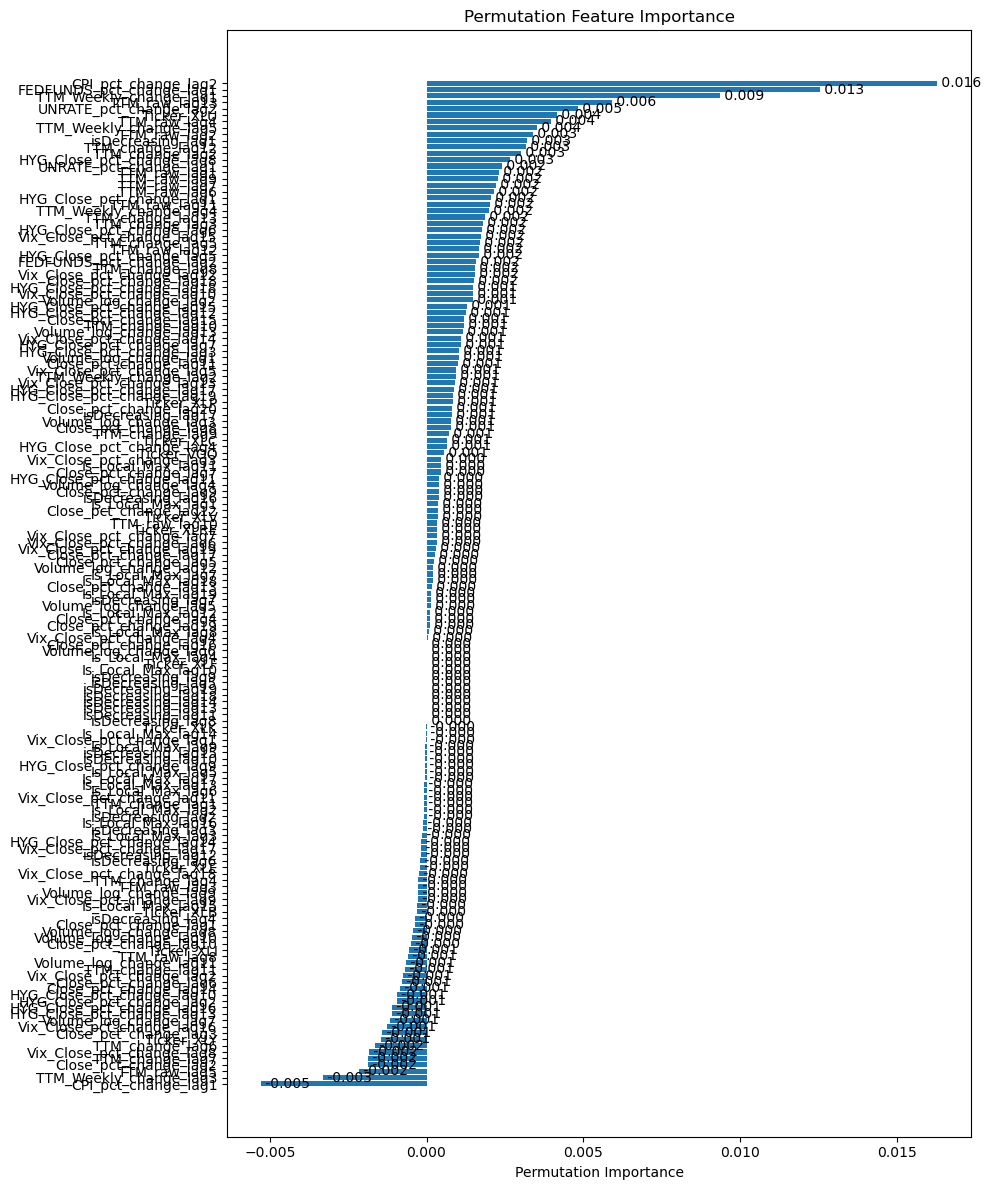

CPI_pct_change_lag2 : 0.016 +/- 0.003
FEDFUNDS_pct_change_lag1: 0.013 +/- 0.002
TTM_Weekly_change_lag1: 0.009 +/- 0.002
TTM_raw_lag13       : 0.006 +/- 0.002
UNRATE_pct_change_lag2: 0.005 +/- 0.002
Ticker_XLU          : 0.004 +/- 0.001
TTM_raw_lag4        : 0.004 +/- 0.001
TTM_Weekly_change_lag5: 0.004 +/- 0.002
TTM_raw_lag2        : 0.003 +/- 0.001
isDecreasing_lag1   : 0.003 +/- 0.001
TTM_change_lag12    : 0.003 +/- 0.001
TTM_change_lag2     : 0.003 +/- 0.001
HYG_Close_pct_change_lag8: 0.003 +/- 0.001
UNRATE_pct_change_lag1: 0.002 +/- 0.002
TTM_raw_lag1        : 0.002 +/- 0.002
TTM_raw_lag9        : 0.002 +/- 0.001
TTM_raw_lag7        : 0.002 +/- 0.001
TTM_raw_lag6        : 0.002 +/- 0.001
HYG_Close_pct_change_lag1: 0.002 +/- 0.001
TTM_raw_lag11       : 0.002 +/- 0.002
TTM_Weekly_change_lag4: 0.002 +/- 0.001
TTM_change_lag13    : 0.002 +/- 0.001
TTM_change_lag3     : 0.002 +/- 0.001
HYG_Close_pct_change_lag6: 0.002 +/- 0.001
Vix_Close_pct_change_lag15: 0.002 +/- 0.001
TTM_change_lag5

In [1934]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming you have your model, X_train, and y_train already defined

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()
sorted_features = X_train.columns[sorted_idx]

# Plot the permutation importance
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), sorted_features)
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")

# Add value labels to the end of each bar
for i, v in enumerate(result.importances_mean[sorted_idx]):
    plt.text(v, i, f" {v:.3f}", va='center')

plt.tight_layout()
plt.show()

# Print the feature importances
keep_columns=[]
for i in sorted_idx[::-1]:
    print(f"{X_train.columns[i]:<20}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")
    if result.importances_mean[i]>0:
        keep_columns.append(X_train.columns[i])


# Improve the model by removing features that negatively impact it's performance.

In [1936]:

X_train = train[keep_columns]
y_train=train['Action']
X_test = test[keep_columns]
y_test=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5818320465160614
Recall 0.7275731042458286
F1_score 0.6675255778704055
              precision    recall  f1-score   support

       False       0.51      0.38      0.44      4438
        True       0.62      0.73      0.67      6053

    accuracy                           0.58     10491
   macro avg       0.56      0.56      0.55     10491
weighted avg       0.57      0.58      0.57     10491



**Removing the features improves the model accuracy, recall and f1_score**

In [1938]:
print_custom_confusion_matrix(y_test, y_pred)
print_custom_confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
negative_recall = tn / (tn + fp)
print('Specificity (True Negative Rate): ',negative_recall)

False Negatives: 1649
True Negatives: 1700

Additional Information:
True Positives: 4404
False Positives: 2738

Percentages:
False Negatives: 15.72%
True Negatives: 16.20%
True Positives: 41.98%
False Positives: 26.10%
False Negatives: 1649
True Negatives: 1700

Additional Information:
True Positives: 4404
False Positives: 2738

Percentages:
False Negatives: 15.72%
True Negatives: 16.20%
True Positives: 41.98%
False Positives: 26.10%
Specificity (True Negative Rate):  0.3830554303740424


['Ticker_XLB', 'Ticker_XLK', 'Ticker_XLY']


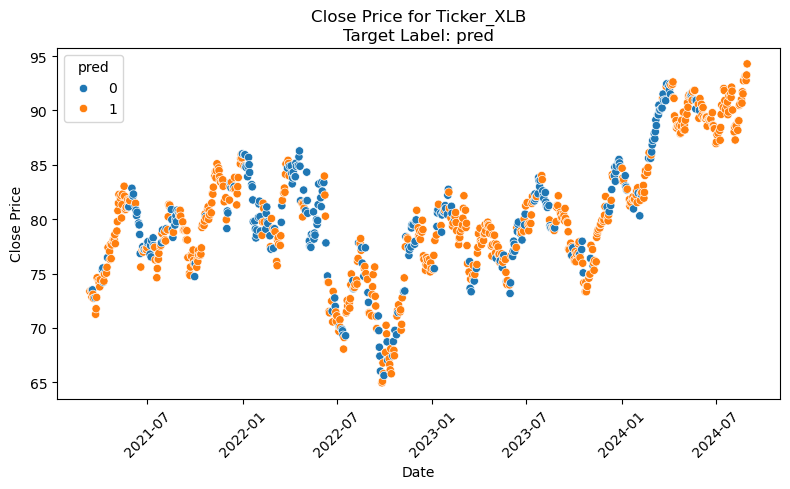

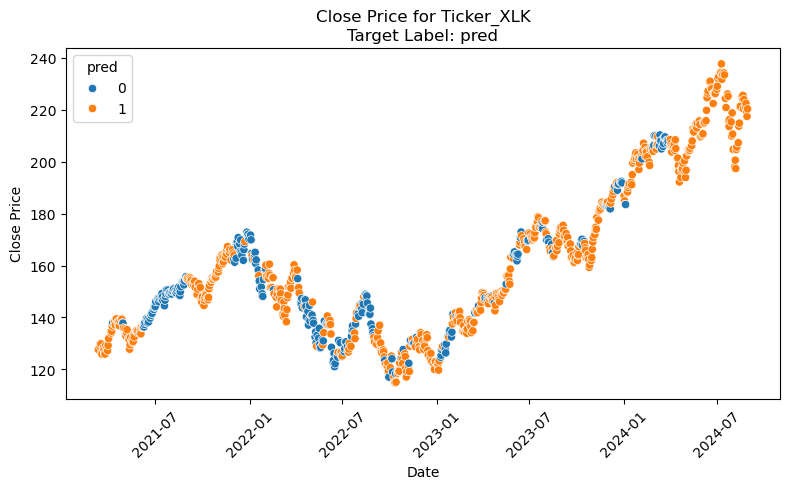

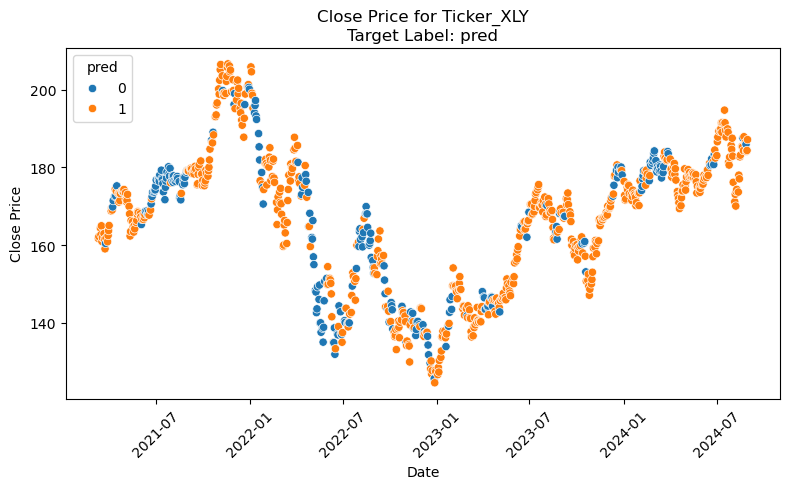

In [1939]:
test['pred']=y_pred
plot_hue_column2(test,column='pred',plot_three=True)

# Look at the actual percentage changes of the predicted invest days compared to the predicted non_invest days.

In [1941]:
print('Average Percentage Change for Invest Days')
print(f"{test[test['pred']==1]['Future_pct_change'].mean()*100}%")

Average Percentage Change for Invest Days
1.4175080218463925%


In [1942]:
print('Average Percentage Change for Non Invest Days')
print(f"{test[test['pred']!=1]['Future_pct_change'].mean()*100}%")


Average Percentage Change for Non Invest Days
-0.19224867896679163%


**It is encouraging that the predicted invest days have a positive average percent change and non_invest days have a negative average percent change**

# Adjust (reduce) the probability Threshold to elimate the occurence of false negatives.

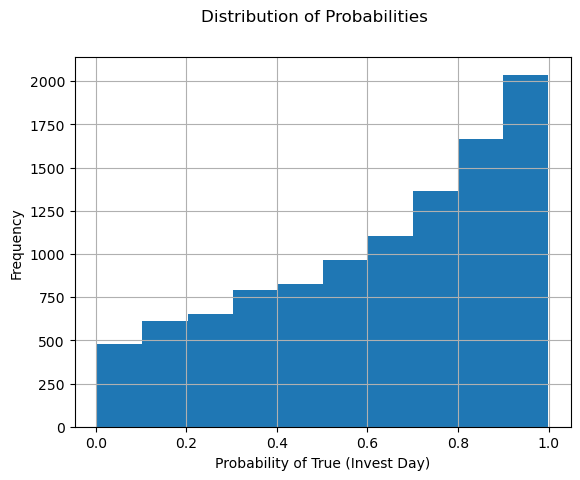

In [1945]:
y_pred_proba = model.predict_proba(X_test)
test['pred_prob']=y_pred_proba[:,1] #Probability of invest day
fig, ax=plt.subplots()
test['pred_prob'].hist(ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Distribution of Probabilities')
plt.show()

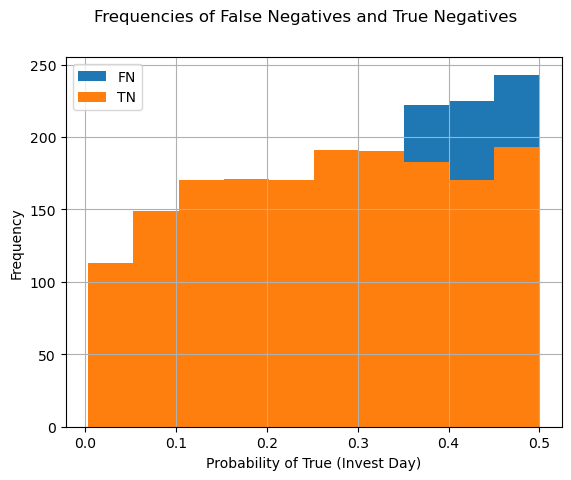

In [1946]:
test['False_negative']=(test['Action'])&(~test['pred'])
fig,ax=plt.subplots()
test[test['False_negative']]['pred_prob'].hist(ax=ax,label='FN')
test['True_negative']=(~test['Action'])&(~test['pred'])
test[test['True_negative']]['pred_prob'].hist(label='TN',ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Frequencies of False Negatives and True Negatives')
plt.legend()

**Graph shows that in the range 0.3 to 0.5 there are more False negatives than True Negatives, This indicates that using a threshold of 0.3 instead of 0.5 will improve model accuracy and possibly the overall net gain associated with using the model.  Doing this Just means that if the model is going to predict a non_invest day, it is going to do it with more confidence.  However, at the same time, predicting an invest day requires less confidence.**

In [1948]:
test['Predicted_Action2']=test['pred_prob']>=0.25 #Used a threshold of 0.35
non_invest_avg_change=test[~test['Predicted_Action2']]['Future_pct_change'].mean()
invest_avg_change=test[test['Predicted_Action2']]['Future_pct_change'].mean()
print('*'*15,'Results After Adjustment','*'*15)
print()
print('Average Percentage Change for Non Invest Days', f"{non_invest_avg_change*100}%")
print('Average Percentage Change for Invest Days', f"{invest_avg_change*100}%")

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -1.1309260232041505%
Average Percentage Change for Invest Days 1.2066000710942768%


**The result is a much larger negative percentage in the non_invest day data.  Presumably, we have isolated the days that are associated with significant negative change.  This is done at the expense of classifying days with less significant negative change as invest days. Below shows the number of industry/date combinations that are predicted as invest and non invest. The final model scores are also shown below.**

In [1950]:
test['Predicted_Action2'].value_counts()

Predicted_Action2
True     9122
False    1369
Name: count, dtype: int64

In [1951]:
print('Accuracy',accuracy_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('Recall',recall_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('F1_Score',f1_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print_custom_confusion_matrix(test['Action'].astype(int),test['Predicted_Action2'].astype(int))

Accuracy 0.5932704222667048
Recall 0.9010408062117958
F1_Score 0.7188138385502472
False Negatives: 599
True Negatives: 770

Additional Information:
True Positives: 5454
False Positives: 3668

Percentages:
False Negatives: 5.71%
True Negatives: 7.34%
True Positives: 51.99%
False Positives: 34.96%


**We see that now the model identifies around 89% of the actual profitable investment days as such.  The True negatives now represent a higher percentage than the False Negatives.  The True positive percent has increased by a higher percent than the False positive percent.  The overall affect is a model with a higher overall accuracy and f1_score.**

# Model Explainer

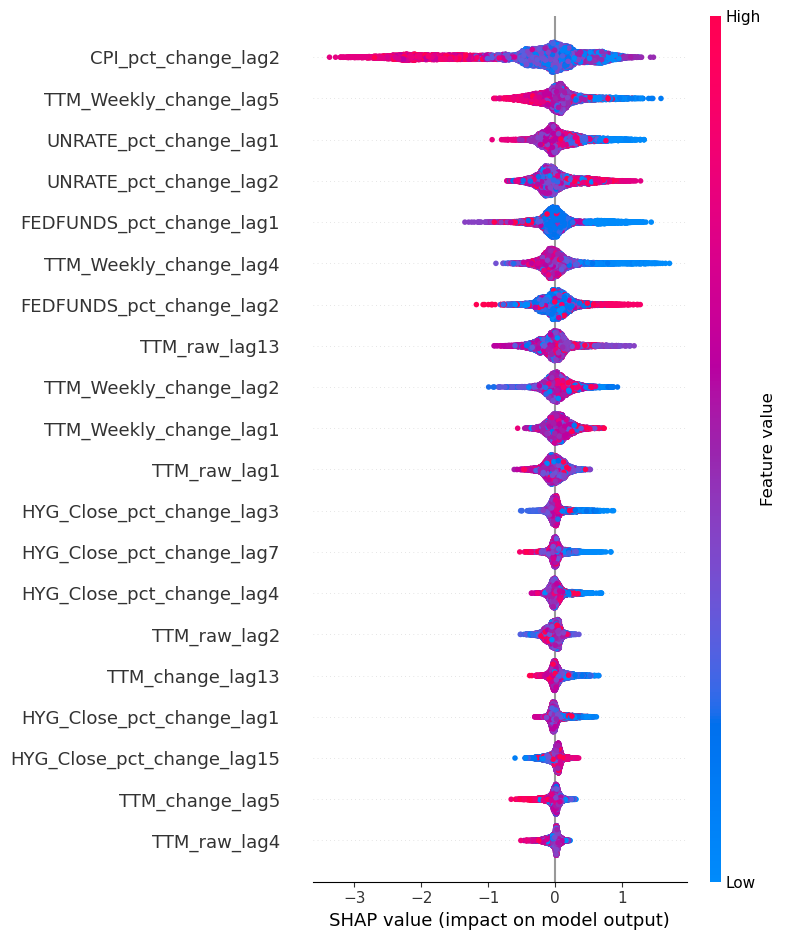

In [1954]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.plots.force(shap_values[0])  # Change the index for different predictions


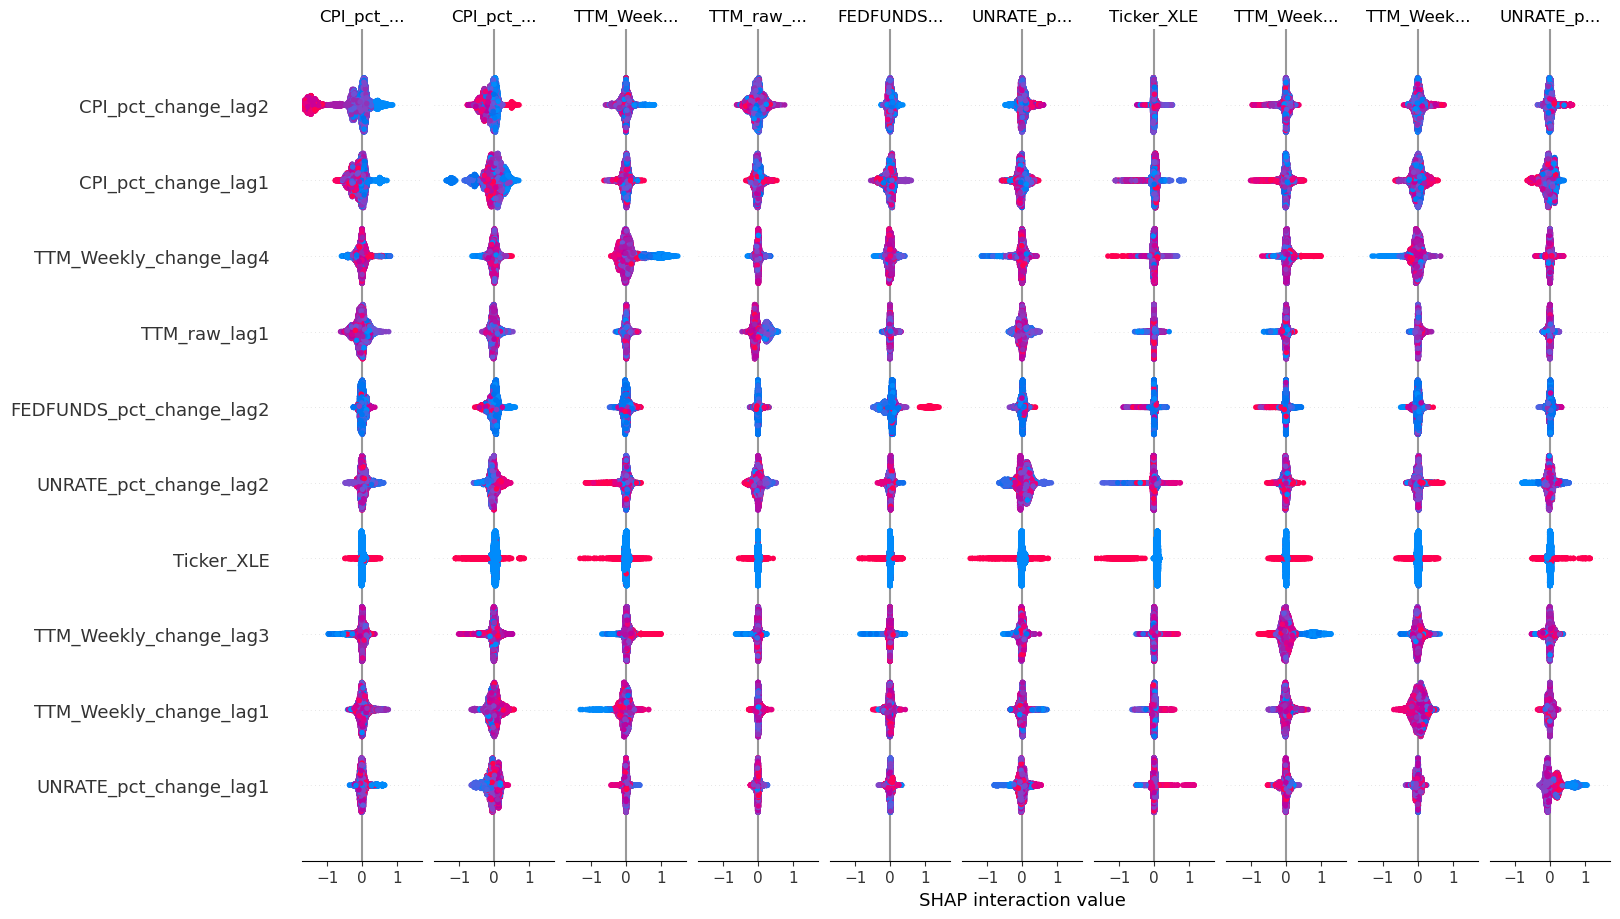

In [1853]:
# Calculate SHAP interaction values
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)

# Visualize the most important interaction effects
shap.summary_plot(shap_interaction_values, X_test, max_display=10)


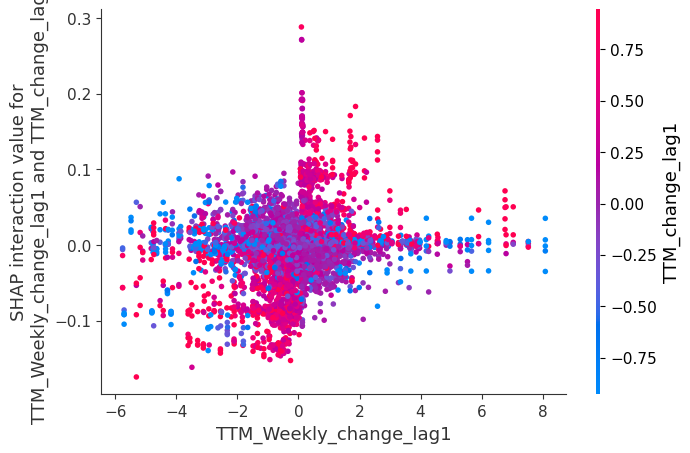

In [1871]:
# Choose two features you're interested in
feature1 = X_test.columns[9]  # Replace with your feature name
feature2 = X_test.columns[12]  # Replace with your feature name

shap.dependence_plot(
    (feature1, feature2),
    shap_interaction_values, X_test,
    display_features=X_test
)


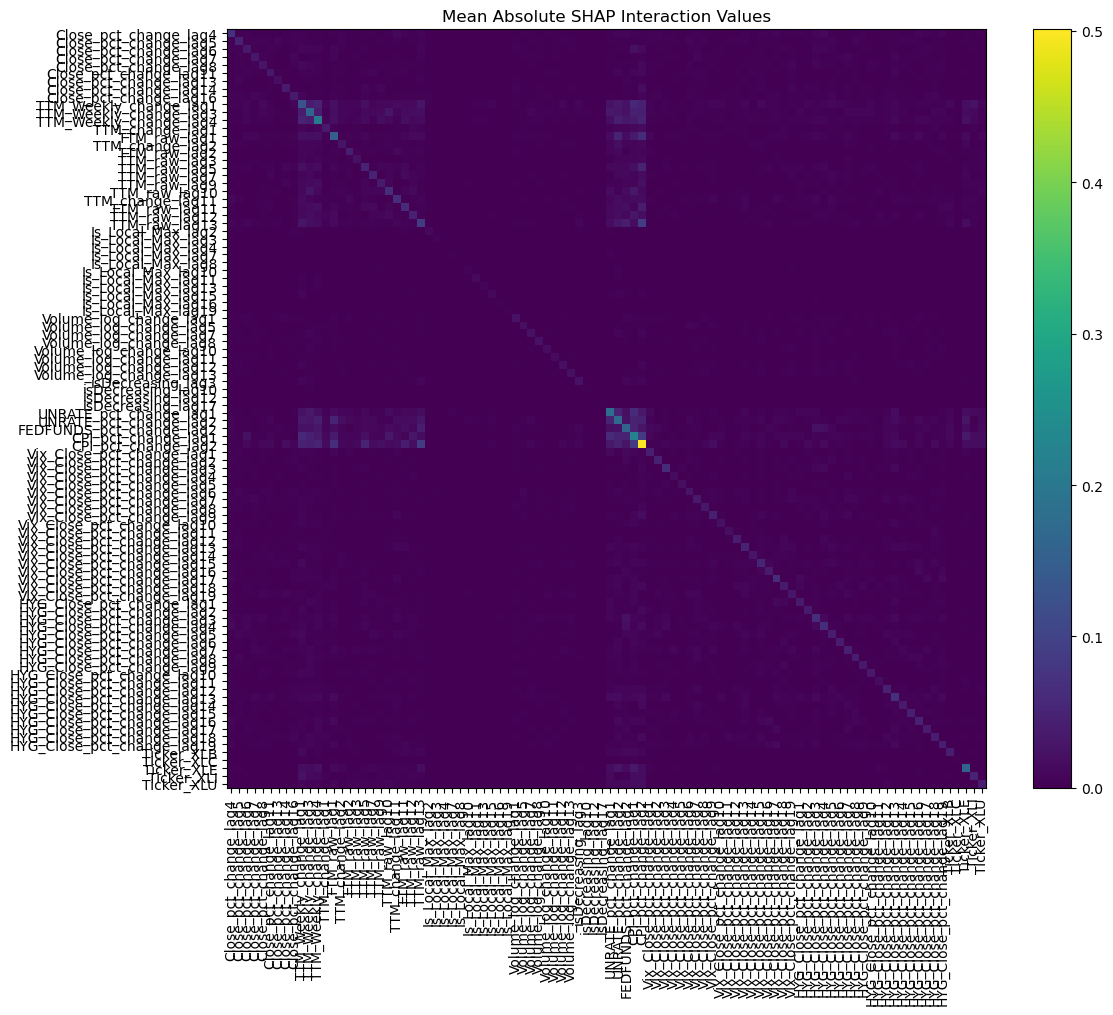

In [1877]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean absolute SHAP interaction values
mean_abs_shap_interaction = np.abs(shap_interaction_values).mean(axis=0)

# Plot the interaction heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(mean_abs_shap_interaction)
ax.set_xticks(np.arange(len(X_test.columns)))
ax.set_yticks(np.arange(len(X_test.columns)))
ax.set_xticklabels(X_test.columns, rotation=90)
ax.set_yticklabels(X_test.columns)
plt.colorbar(im)
plt.title("Mean Absolute SHAP Interaction Values")
plt.tight_layout()
plt.show()


array([[7.3763870e-02, 2.2412988e-03, 4.4909143e-03, ..., 3.2489181e-03,
        3.4218069e-04, 3.1752270e-03],
       [2.2413000e-03, 4.6496790e-02, 4.3929573e-03, ..., 2.7850172e-03,
        9.2527480e-04, 5.4701132e-04],
       [4.4909138e-03, 4.3929592e-03, 3.4145851e-02, ..., 2.5502645e-04,
        3.8243588e-03, 8.5506465e-05],
       ...,
       [3.2489160e-03, 2.7850186e-03, 2.5502671e-04, ..., 1.6201034e-01,
        1.4637472e-03, 4.9647572e-04],
       [3.4218020e-04, 9.2527492e-04, 3.8243586e-03, ..., 1.4637486e-03,
        4.9627412e-02, 1.2145924e-04],
       [3.1752256e-03, 5.4701150e-04, 8.5506465e-05, ..., 4.9647567e-04,
        1.2145929e-04, 3.8666040e-02]], dtype=float32)

# The data is written to csv so that it can be further tested using investment simulation.

In [1828]:
test['Predicted_Action']=test['pred']
test['Predicted_Action2']=test['Predicted_Action2'].astype(int)
data=test[test['Year']>=2022]
data['Date']=data['Date'].dt.date
data[['Date','Predicted_Action','Predicted_Action2']+[col for col in test.columns if 'Ticker' in col]].to_csv('Action_Data.csv',index=False)

# Plots of investment/non_investment days.  Non_investment days (blue)

['Ticker_XLB', 'Ticker_XLK', 'Ticker_XLY']


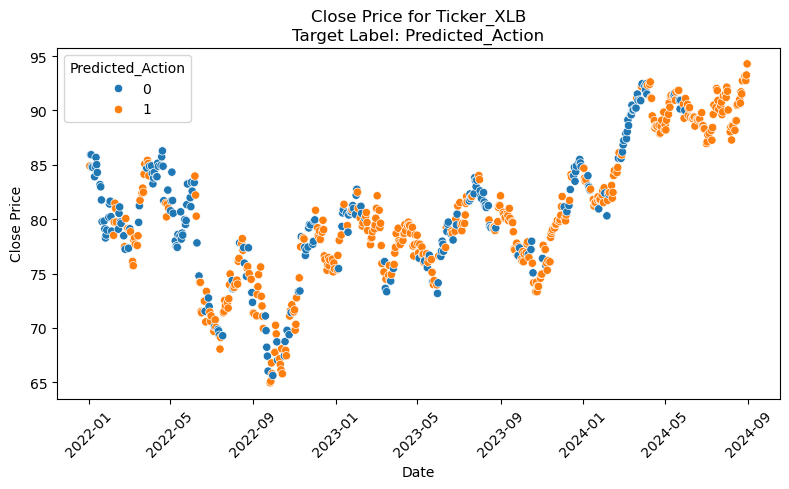

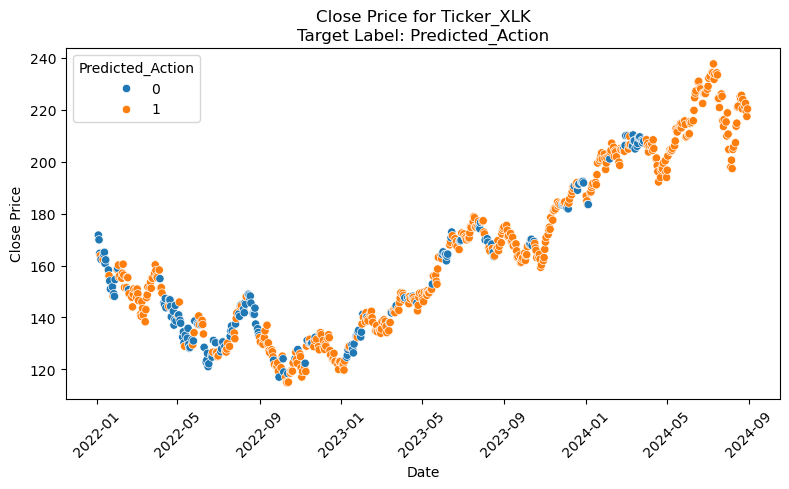

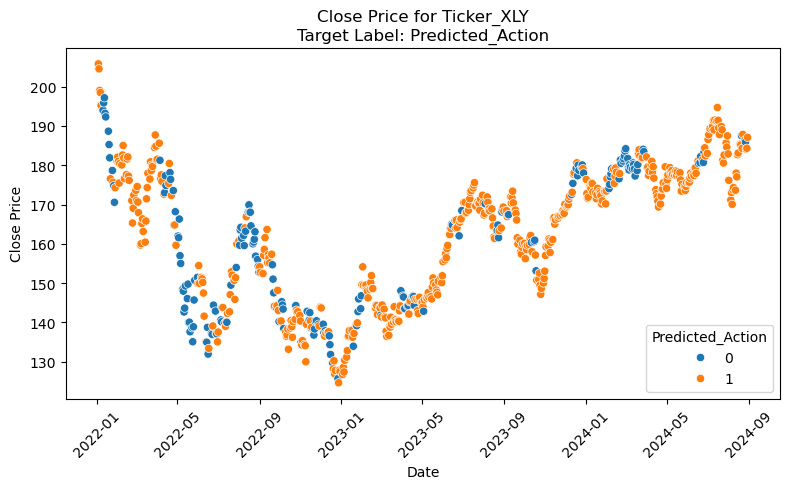

In [1830]:
plot_hue_column2(data,column='Predicted_Action',plot_three=True)

Fold 1 Results:
              precision    recall  f1-score   support

       False       0.37      0.13      0.19      2479
        True       0.56      0.84      0.67      3305

    accuracy                           0.53      5784
   macro avg       0.47      0.48      0.43      5784
weighted avg       0.48      0.53      0.47      5784


Fold 2 Results:
              precision    recall  f1-score   support

       False       0.39      0.32      0.35      2029
        True       0.67      0.73      0.70      3755

    accuracy                           0.59      5784
   macro avg       0.53      0.53      0.52      5784
weighted avg       0.57      0.59      0.58      5784


Fold 3 Results:
              precision    recall  f1-score   support

       False       0.39      0.23      0.29      1989
        True       0.67      0.81      0.73      3795

    accuracy                           0.61      5784
   macro avg       0.53      0.52      0.51      5784
weighted avg       0.57 

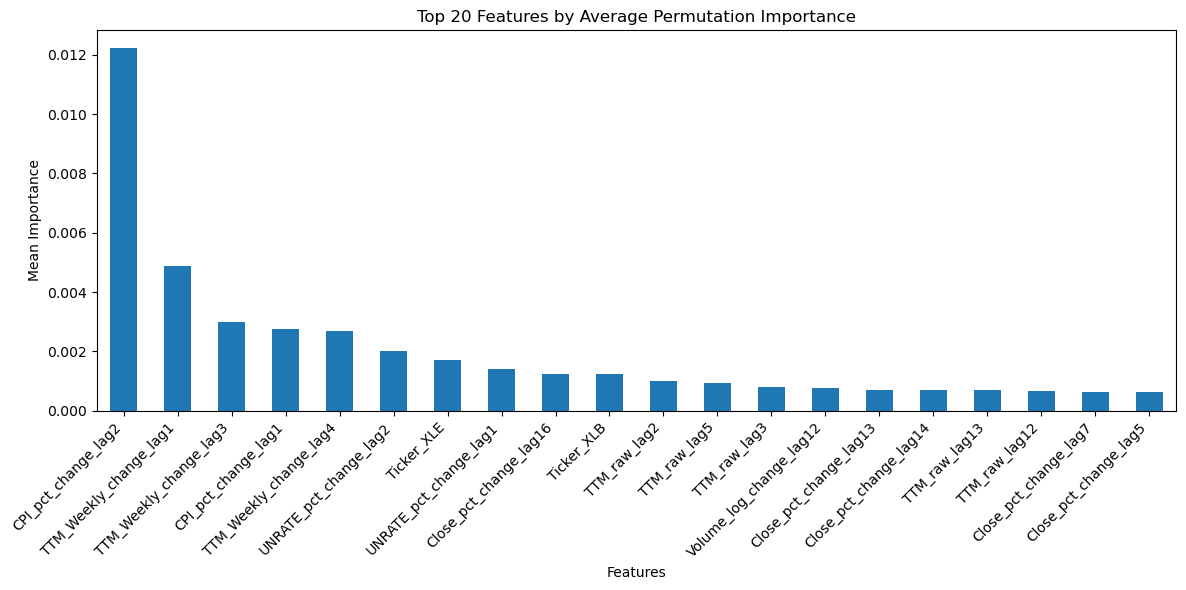


Features that consistently increase the loss function:
['isDecreasing_lag11', 'Volume_log_change_lag6', 'isDecreasing_lag4', 'TTM_raw_lag8', 'Is_Local_Max_lag17', 'TTM_change_lag3', 'Close_pct_change_lag19', 'Ticker_XLF', 'isDecreasing_lag19', 'Is_Local_Max_lag18', 'isDecreasing_lag18', 'Close_pct_change_lag12', 'Is_Local_Max_lag12', 'Ticker_VOO', 'Is_Local_Max_lag6', 'Is_Local_Max_lag5', 'isDecreasing_lag8', 'isDecreasing_lag15', 'isDecreasing_lag14', 'isDecreasing_lag6', 'isDecreasing_lag5', 'Is_Local_Max_lag1', 'TTM_change_lag7', 'Volume_log_change_lag4', 'isDecreasing_lag2', 'TTM_change_lag12', 'isDecreasing_lag7', 'isDecreasing_lag16', 'Ticker_XLY', 'TTM_change_lag9', 'Close_pct_change_lag18', 'isDecreasing_lag9', 'Volume_log_change_lag9', 'Is_Local_Max_lag14', 'Ticker_XLRE', 'isDecreasing_lag13', 'Ticker_XLK', 'Close_pct_change_lag9', 'TTM_change_lag6', 'Close_pct_change_lag2', 'Is_Local_Max_lag9', 'Close_pct_change_lag20', 'TTM_change_lag4', 'Volume_log_change_lag2', 'Close_pct

In [1831]:
def calculate_permutation_importance(model, X, y):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=1
    )
    return pd.DataFrame({
        'feature': X.columns,
        'importance': result.importances_mean
    })
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
import xgboost as xgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Your existing code for data preparation...

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store results
accuracies = []
recalls = []
f1_scores = []
feature_importances = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train your model
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Print detailed classification report for each fold
    print(f"Fold {fold} Results:\n{classification_report(y_test, y_pred)}\n")

    # Perform permutation feature importance
    fold_importance = calculate_permutation_importance(model, X_test, y_test)
    feature_importances.append(fold_importance)

# Print average performance metrics
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

# Calculate average feature importance across all folds
avg_importance = pd.concat(feature_importances).groupby('feature').mean().sort_values('importance', ascending=False)

# Print average feature importance
print("\nAverage Permutation Feature Importance:")
print(avg_importance)

# Plot average feature importance
plt.figure(figsize=(12, 6))
avg_importance['importance'][:20].plot(kind='bar')
plt.title('Top 20 Features by Average Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify features that consistently increase the loss function
consistent_negative_features = avg_importance[avg_importance['importance'] < 0].index.tolist()

print("\nFeatures that consistently increase the loss function:")
print(consistent_negative_features)

# Remove consistently negative features
X_important = X.drop(columns=consistent_negative_features)

# You can now use X_important for further modeling if desired



In [1832]:
keep_columns2=[col for col in features if col not in consistent_negative_features]
X_train = train[keep_columns2]
y_train=train['Action']
X_test = test[keep_columns2]
y_test=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5479935182537413
Recall 0.739302825045432
F1_score 0.6536663745252702
              precision    recall  f1-score   support

       False       0.45      0.29      0.35      4438
        True       0.59      0.74      0.65      6053

    accuracy                           0.55     10491
   macro avg       0.52      0.51      0.50     10491
weighted avg       0.53      0.55      0.53     10491



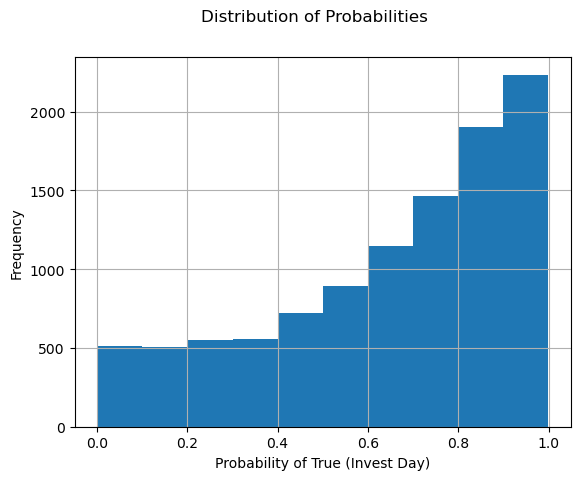

In [1833]:
test['pred']=y_pred
y_pred_proba = model.predict_proba(X_test)
test['pred_prob']=y_pred_proba[:,1] #Probability of invest day
fig, ax=plt.subplots()
test['pred_prob'].hist(ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Distribution of Probabilities')
plt.show()

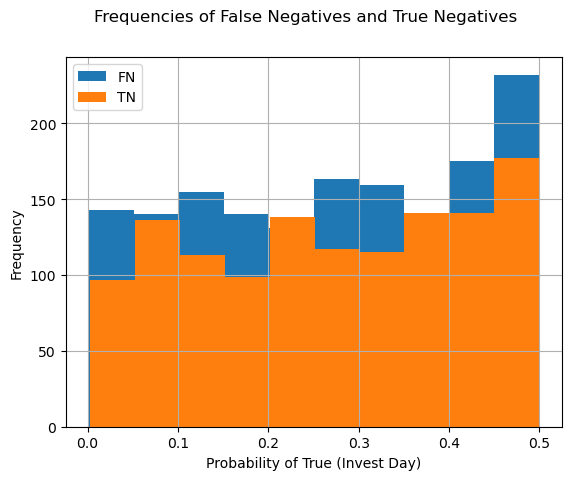

In [1834]:
test['False_negative']=(test['Action'])&(~test['pred'])
fig,ax=plt.subplots()
test[test['False_negative']]['pred_prob'].hist(ax=ax,label='FN')
test['True_negative']=(~test['Action'])&(~test['pred'])
test[test['True_negative']]['pred_prob'].hist(label='TN',ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Frequencies of False Negatives and True Negatives')
plt.legend()

In [1835]:
test['Predicted_Action2']=test['pred_prob']>=0.25 #Used a threshold of 0.25
non_invest_avg_change=test[~test['Predicted_Action2']]['Future_pct_change'].mean()
invest_avg_change=test[test['Predicted_Action2']]['Future_pct_change'].mean()
print('*'*15,'Results After Adjustment','*'*15)
print()
print('Average Percentage Change for Non Invest Days', f"{non_invest_avg_change*100}%")
print('Average Percentage Change for Invest Days', f"{invest_avg_change*100}%")

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days 0.43046713195084546%
Average Percentage Change for Invest Days 0.962732610307306%


In [1836]:
print('Accuracy',accuracy_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('Recall',recall_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('F1_Score',f1_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print_custom_confusion_matrix(test['Action'].astype(int),test['Predicted_Action2'].astype(int))

Accuracy 0.5648651224859403
Recall 0.8833636213447877
F1_Score 0.7008322956943444
False Negatives: 706
True Negatives: 579

Additional Information:
True Positives: 5347
False Positives: 3859

Percentages:
False Negatives: 6.73%
True Negatives: 5.52%
True Positives: 50.97%
False Positives: 36.78%


In [1837]:
print(test['pred_prob'].describe())


count    10491.000000
mean         0.651727
std          0.272666
min          0.000907
25%          0.471060
50%          0.726844
75%          0.880877
max          0.998849
Name: pred_prob, dtype: float64


In [1838]:
y_pred_proba

array([[0.01016992, 0.9898301 ],
       [0.05260134, 0.94739866],
       [0.01682448, 0.9831755 ],
       ...,
       [0.06974769, 0.9302523 ],
       [0.36738157, 0.6326184 ],
       [0.41743118, 0.5825688 ]], dtype=float32)